<a href="https://colab.research.google.com/github/nworb999/emotiscope/blob/main/emotiscope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [ ]:
!pip install diffusers transformers scipy ftfy accelerate torch torchvision np opencv-python streamlit streamlit-webrtc av pyngrok twilio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00


#Hugging Face Setup

In [ ]:
import os
import getpass

# Securely input the API token
api_token = getpass.getpass("Enter your API token:")
os.environ["HF_TOKEN"] = api_token

Enter your API token:··········


# Clear CUDA cache

In [ ]:
import torch
torch.cuda.empty_cache()


# Facial Expression Recognition Functions

In [ ]:
import numpy as np
import math
import cv2 as cv2
import time as time

image_mean = np.array([127, 127, 127])
image_std = 128.0
iou_threshold = 0.3
center_variance = 0.1
size_variance = 0.2
min_boxes = [
    [10.0, 16.0, 24.0],
    [32.0, 48.0],
    [64.0, 96.0],
    [128.0, 192.0, 256.0]
]
strides = [8.0, 16.0, 32.0, 64.0]
threshold = 0.5

In [ ]:
def generate_priors(feature_map_list, shrinkage_list, image_size, min_boxes):
    priors = []
    for index in range(0, len(feature_map_list[0])):
        scale_w = image_size[0] / shrinkage_list[0][index]
        scale_h = image_size[1] / shrinkage_list[1][index]
        for j in range(0, feature_map_list[1][index]):
            for i in range(0, feature_map_list[0][index]):
                x_center = (i + 0.5) / scale_w
                y_center = (j + 0.5) / scale_h

                for min_box in min_boxes[index]:
                    w = min_box / image_size[0]
                    h = min_box / image_size[1]
                    priors.append([
                        x_center,
                        y_center,
                        w,
                        h
                    ])
    print("priors nums:{}".format(len(priors)))
    return np.clip(priors, 0.0, 1.0)

In [ ]:
def define_img_size(image_size):
    shrinkage_list = []
    feature_map_w_h_list = []
    for size in image_size:
        feature_map = [int(math.ceil(size / stride)) for stride in strides]
        feature_map_w_h_list.append(feature_map)

    for i in range(0, len(image_size)):
        shrinkage_list.append(strides)
    priors = generate_priors(
        feature_map_w_h_list, shrinkage_list, image_size, min_boxes
    )
    return priors

In [ ]:
def area_of(left_top, right_bottom):
    hw = np.clip(right_bottom - left_top, 0.0, None)
    return hw[..., 0] * hw[..., 1]


def iou_of(boxes0, boxes1, eps=1e-5):
    overlap_left_top = np.maximum(boxes0[..., :2], boxes1[..., :2])
    overlap_right_bottom = np.minimum(boxes0[..., 2:], boxes1[..., 2:])

    overlap_area = area_of(overlap_left_top, overlap_right_bottom)
    area0 = area_of(boxes0[..., :2], boxes0[..., 2:])
    area1 = area_of(boxes1[..., :2], boxes1[..., 2:])
    return overlap_area / (area0 + area1 - overlap_area + eps)

In [ ]:
def hard_nms(box_scores, iou_threshold, top_k=-1, candidate_size=200):
    scores = box_scores[:, -1]
    boxes = box_scores[:, :-1]
    picked = []
    indexes = np.argsort(scores)
    indexes = indexes[-candidate_size:]
    while len(indexes) > 0:
        current = indexes[-1]
        picked.append(current)
        if 0 < top_k == len(picked) or len(indexes) == 1:
            break
        current_box = boxes[current, :]
        indexes = indexes[:-1]
        rest_boxes = boxes[indexes, :]
        iou = iou_of(
            rest_boxes,
            np.expand_dims(current_box, axis=0),
        )
        indexes = indexes[iou <= iou_threshold]
    return box_scores[picked, :]

In [ ]:
def predict(
    width,
    height,
    confidences,
    boxes,
    prob_threshold,
    iou_threshold=0.3,
    top_k=-1
):
    boxes = boxes[0]
    confidences = confidences[0]
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate(
            [subset_boxes, probs.reshape(-1, 1)], axis=1
        )
        box_probs = hard_nms(box_probs,
                             iou_threshold=iou_threshold,
                             top_k=top_k,
                             )
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return (
        picked_box_probs[:, :4].astype(np.int32),
        np.array(picked_labels),
        picked_box_probs[:, 4]
    )

In [ ]:
def convert_locations_to_boxes(locations, priors, center_variance,
                               size_variance):
    if len(priors.shape) + 1 == len(locations.shape):
        priors = np.expand_dims(priors, 0)
    return np.concatenate([
        locations[..., :2] * center_variance * priors[..., 2:] + priors[..., :2],
        np.exp(locations[..., 2:] * size_variance) * priors[..., 2:]
    ], axis=len(locations.shape) - 1)


def center_form_to_corner_form(locations):
    return np.concatenate(
        [locations[..., :2] - locations[..., 2:] / 2,
         locations[..., :2] + locations[..., 2:] / 2],
        len(locations.shape) - 1
    )

In [ ]:
import urllib.request
from pathlib import Path

import streamlit as st


# This code is based on https://github.com/streamlit/demo-self-driving/blob/230245391f2dda0cb464008195a470751c01770b/streamlit_app.py#L48  # noqa: E501
# and I, Emma, ripped this from https://huggingface.co/spaces/sadimanna/face-emotion-recognition/

def download_file(url, download_to: Path, expected_size=None):
    # Don't download the file twice.
    # (If possible, verify the download using the file length.)
    if download_to.exists():
        if expected_size:
            if download_to.stat().st_size == expected_size:
                return
        else:
            st.info(f"{url} is already downloaded.")
            if not st.button("Download again?"):
                return

    download_to.parent.mkdir(parents=True, exist_ok=True)

    # These are handles to two visual elements to animate.
    weights_warning, progress_bar = None, None
    try:
        weights_warning = st.warning("Downloading %s..." % url)
        progress_bar = st.progress(0)
        with open(download_to, "wb") as output_file:
            with urllib.request.urlopen(url) as response:
                length = int(response.info()["Content-Length"])
                counter = 0.0
                MEGABYTES = 2.0 ** 20.0
                while True:
                    data = response.read(8192)
                    if not data:
                        break
                    counter += len(data)
                    output_file.write(data)

                    # We perform animation by overwriting the elements.
                    weights_warning.warning(
                        "Downloading %s... (%6.2f/%6.2f MB)"
                        % (url, counter / MEGABYTES, length / MEGABYTES)
                    )
                    progress_bar.progress(min(counter / length, 1.0))
    # Finally, we remove these visual elements by calling .empty().
    finally:
        if weights_warning is not None:
            weights_warning.empty()
        if progress_bar is not None:
            progress_bar.empty()

In [ ]:
HERE = Path.cwd()
ROOT = HERE

ONNX_MODEL_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/emotion-ferplus-8.onnx"
ONNX_MODEL_LOCAL_PATH = ROOT / "./emotion-ferplus-8.onnx"
CAFFE_MODEL_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/RFB-320/RFB-320.caffemodel"  # noqa: E501
CAFFE_MODEL_LOCAL_PATH = ROOT / "./RFB-320/RFB-320.caffemodel"
PROTOTXT_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/RFB-320/RFB-320.prototxt"  # noqa: E501
PROTOTXT_LOCAL_PATH = ROOT / "./RFB-320/RFB-320.prototxt"

download_file(CAFFE_MODEL_URL, CAFFE_MODEL_LOCAL_PATH) #, expected_size=23147564)
download_file(ONNX_MODEL_URL, ONNX_MODEL_LOCAL_PATH) #, expected_size=23147564)
download_file(PROTOTXT_URL, PROTOTXT_LOCAL_PATH) #, expected_size=29353)

# Live Camera Capture

In [ ]:
def FER_live_cam():
    emotion_dict = {
        0: 'neutral',
        1: 'happiness',
        2: 'surprise',
        3: 'sadness',
        4: 'anger',
        5: 'disgust',
        6: 'fear'
    }

    # cap = cv2.VideoCapture('video1.mp4')
    cap = cv2.VideoCapture(0)

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    size = (frame_width, frame_height)
    result = cv2.VideoWriter('result.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # Read ONNX model
    # model = 'onnx_model.onnx'
    model = cv2.dnn.readNetFromONNX('emotion-ferplus-8.onnx')

    # Read the Caffe face detector.
    model_path = 'RFB-320/RFB-320.caffemodel'
    proto_path = 'RFB-320/RFB-320.prototxt'
    net = cv2.dnn.readNetFromCaffe(proto_path, model_path)
    input_size = [320, 240]
    width = input_size[0]
    height = input_size[1]
    priors = define_img_size(input_size)

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            img_ori = frame
            #print("frame size: ", frame.shape)
            rect = cv2.resize(img_ori, (width, height))
            rect = cv2.cvtColor(rect, cv2.COLOR_BGR2RGB)
            net.setInput(cv2.dnn.blobFromImage(
                rect, 1 / image_std, (width, height), 127)
            )
            start_time = time.time()
            boxes, scores = net.forward(["boxes", "scores"])
            boxes = np.expand_dims(np.reshape(boxes, (-1, 4)), axis=0)
            scores = np.expand_dims(np.reshape(scores, (-1, 2)), axis=0)
            boxes = convert_locations_to_boxes(
                boxes, priors, center_variance, size_variance
            )
            boxes = center_form_to_corner_form(boxes)
            boxes, labels, probs = predict(
                img_ori.shape[1],
                img_ori.shape[0],
                scores,
                boxes,
                threshold
            )
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            for (x1, y1, x2, y2) in boxes:
                w = x2 - x1
                h = y2 - y1
                cv2.rectangle(frame, (x1,y1), (x2, y2), (255,0,0), 2)
                resize_frame = cv2.resize(
                    gray[y1:y1 + h, x1:x1 + w], (64, 64)
                )
                resize_frame = resize_frame.reshape(1, 1, 64, 64)
                model.setInput(resize_frame)
                output = model.forward()
                end_time = time.time()
                fps = 1 / (end_time - start_time)
                print(f"FPS: {fps:.1f}")
                pred = emotion_dict[list(output[0]).index(max(output[0]))]
                cv2.rectangle(
                    img_ori,
                    (x1, y1),
                    (x2, y2),
                    (0, 255, 0),
                    2,
                    lineType=cv2.LINE_AA
                )
                cv2.putText(
                    frame,
                    pred,
                    (x1, y1),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    (0, 255, 0),
                    2,
                    lineType=cv2.LINE_AA
                )

            result.write(frame)

            cv2.imshow('frame', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    result.release()
    cv2.destroyAllWindows()

<IPython.core.display.Javascript object>

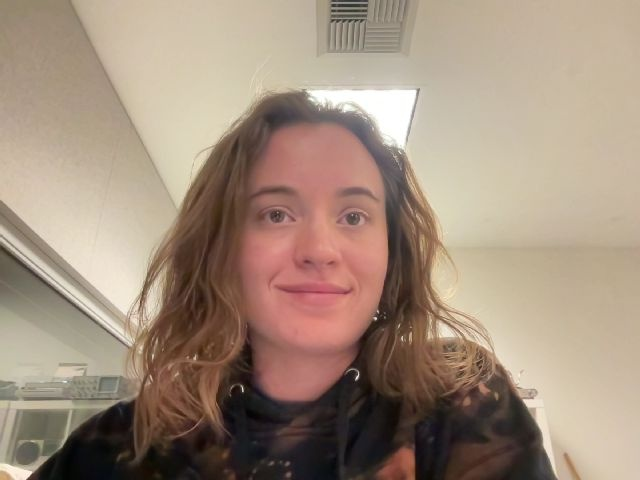

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import io

# Define the emotion dictionary
emotion_dict = {
    0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness',
    4: 'anger', 5: 'disgust', 6: 'fear'
}

# Load models
# Assuming you have already downloaded these models to your Colab environment
model = cv2.dnn.readNetFromONNX('emotion-ferplus-8.onnx')
net = cv2.dnn.readNetFromCaffe('RFB-320/RFB-320.prototxt', 'RFB-320/RFB-320.caffemodel')

# Define the image size for the face detector
input_size = [320, 240]

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


def process_image(image_path):
    # Read the image
    frame = cv2.imread(image_path)

    # Prepare the frame
    frame_resized = cv2.resize(frame, (input_size[0], input_size[1]))
    blob = cv2.dnn.blobFromImage(frame_resized, scalefactor=1.0, size=(input_size[0], input_size[1]), mean=(104.0, 177.0, 123.0))

    # Set the input to the network
    net.setInput(blob)

    # Run the detection
    detections = net.forward()

    # Ensure detections array is not empty and has expected dimensions
    with open('emotion_results.txt', 'w') as file:
      file.write("Detection results:\n")
      file.write("Format: Emotion, Confidence, Box Coordinates (startX, startY, endX, endY)\n")
      if detections is not None and len(detections.shape) == 4 and detections.shape[2] > 0:
          # Loop over the detections
          for i in range(0, detections.shape[2]):
              confidence = detections[0, 0, i, 2]
              if confidence > 0.5:
                  # Compute the (x, y)-coordinates of the bounding box for the object
                  box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
                  (startX, startY, endX, endY) = box.astype("int")

                  # Extract the ROI of the face
                  face = frame[startY:endY, startX:endX]
                  face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                  face_resized = cv2.resize(face_gray, (64, 64)).reshape(1, 1, 64, 64)

                  # Make a prediction on the ROI
                  model.setInput(face_resized)
                  preds = model.forward()
                  emotion = emotion_dict[np.argmax(preds)]


                  # Draw the face detection + emotion label on the image
                  text = "{}: {:.2f}%".format(emotion, confidence * 100)
                  cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
                  cv2.putText(frame, text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
                  file.write(f"{emotion}, {confidence:.2f}, ({startX}, {startY}, {endX}, {endY})\n")


    # Save the result
    cv2.imwrite('result.jpg', frame)

    # Display the image in the notebook
    display(Image(filename='result.jpg'))


# Capture an image from the webcam
image_path = take_photo()

# Process the captured image
process_image(image_path)


# Another Try

In [147]:
import os
import getpass

# Securely input the API token
sid = getpass.getpass("Enter your Twilio SID:")
os.environ["TWILIO_ACCOUNT_SID"] = sid
auth = getpass.getpass("Enter your Twilio auth:")
os.environ["TWILIO_AUTH_TOKEN"] = auth

Enter your Twilio SID:··········
Enter your Twilio auth:··········


In [148]:
import os

import streamlit as st
from twilio.base.exceptions import TwilioRestException
from twilio.rest import Client


def get_ice_servers():
    """Use Twilio's TURN server because Streamlit Community Cloud has changed
    its infrastructure and WebRTC connection cannot be established without TURN server now.  # noqa: E501
    We considered Open Relay Project (https://www.metered.ca/tools/openrelay/) too,
    but it is not stable and hardly works as some people reported like https://github.com/aiortc/aiortc/issues/832#issuecomment-1482420656  # noqa: E501
    See https://github.com/whitphx/streamlit-webrtc/issues/1213
    """

    # Ref: https://www.twilio.com/docs/stun-turn/api
    try:
        account_sid = os.environ["TWILIO_ACCOUNT_SID"]
        auth_token = os.environ["TWILIO_AUTH_TOKEN"]
    except KeyError:
        print(
            "Twilio credentials are not set. Fallback to a free STUN server from Google."  # noqa: E501
        )
        return [{"urls": ["stun:stun.l.google.com:19302"]}]

    client = Client(account_sid, auth_token)

    try:
        token = client.tokens.create()
    except TwilioRestException as e:
        st.warning(
            f"Error occurred while accessing Twilio API. Fallback to a free STUN server from Google. ({e})"  # noqa: E501
        )
        return [{"urls": ["stun:stun.l.google.com:19302"]}]

    return token.ice_servers

In [149]:
"""
Emotion Detection:
Model from: https://github.com/onnx/models/blob/main/vision/body_analysis/emotion_ferplus/model/emotion-ferplus-8.onnx
Model name: emotion-ferplus-8.onnx
"""

import queue
from pathlib import Path
from typing import List, NamedTuple

import cv2
import numpy as np
import time
import os

from cv2 import dnn
from math import ceil

import av
import streamlit as st

HERE = Path(Path.cwd()).parent
ROOT = HERE.parent


ONNX_MODEL_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/emotion-ferplus-8.onnx"
ONNX_MODEL_LOCAL_PATH = ROOT / "./emotion-ferplus-8.onnx"
CAFFE_MODEL_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/RFB-320/RFB-320.caffemodel"  # noqa: E501
CAFFE_MODEL_LOCAL_PATH = ROOT / "./RFB-320/RFB-320.caffemodel"
PROTOTXT_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/RFB-320/RFB-320.prototxt"  # noqa: E501
PROTOTXT_LOCAL_PATH = ROOT / "./RFB-320/RFB-320.prototxt.txt"

download_file(CAFFE_MODEL_URL, CAFFE_MODEL_LOCAL_PATH) #, expected_size=23147564)
download_file(ONNX_MODEL_URL, ONNX_MODEL_LOCAL_PATH) #, expected_size=23147564)
download_file(PROTOTXT_URL, PROTOTXT_LOCAL_PATH) #, expected_size=29353)

# Session-specific caching
onnx_cache_key = "emotion_dnn"
caffe_cache_key = "face_detection_dnn"
if caffe_cache_key in st.session_state and onnx_cache_key in st.session_state:
  model = st.session_state[onnx_cache_key]
  net = st.session_state[caffe_cache_key]
else:
  # Read ONNX model
  model = 'onnx_model.onnx'
  model = cv2.dnn.readNetFromONNX('emotion-ferplus-8.onnx')
  st.session_state[onnx_cache_key] = model
  # Read the Caffe face detector.
  net = cv2.dnn.readNetFromCaffe(str(PROTOTXT_LOCAL_PATH), str(CAFFE_MODEL_LOCAL_PATH))
  st.session_state[caffe_cache_key] = net


########################################
image_mean = np.array([127, 127, 127])
image_std = 128.0
iou_threshold = 0.3
center_variance = 0.1
size_variance = 0.2
min_boxes = [
  [10.0, 16.0, 24.0],
  [32.0, 48.0],
  [64.0, 96.0],
  [128.0, 192.0, 256.0]
]
strides = [8.0, 16.0, 32.0, 64.0]
threshold = 0.5

emotion_dict = {
      0: 'neutral',
      1: 'happiness',
      2: 'surprise',
      3: 'sadness',
      4: 'anger',
      5: 'disgust',
      6: 'fear'
  }
########################################

def define_img_size(image_size):
  shrinkage_list = []
  feature_map_w_h_list = []
  for size in image_size:
      feature_map = [int(ceil(size / stride)) for stride in strides]
      feature_map_w_h_list.append(feature_map)

  for i in range(0, len(image_size)):
      shrinkage_list.append(strides)
  priors = generate_priors(
      feature_map_w_h_list, shrinkage_list, image_size, min_boxes
  )
  return priors


def generate_priors(
  feature_map_list, shrinkage_list, image_size, min_boxes
):
  priors = []
  for index in range(0, len(feature_map_list[0])):
      scale_w = image_size[0] / shrinkage_list[0][index]
      scale_h = image_size[1] / shrinkage_list[1][index]
      for j in range(0, feature_map_list[1][index]):
          for i in range(0, feature_map_list[0][index]):
              x_center = (i + 0.5) / scale_w
              y_center = (j + 0.5) / scale_h

              for min_box in min_boxes[index]:
                  w = min_box / image_size[0]
                  h = min_box / image_size[1]
                  priors.append([
                      x_center,
                      y_center,
                      w,
                      h
                  ])
  print("priors nums:{}".format(len(priors)))
  return np.clip(priors, 0.0, 1.0)


def hard_nms(box_scores, iou_threshold, top_k=-1, candidate_size=200):
  scores = box_scores[:, -1]
  boxes = box_scores[:, :-1]
  picked = []
  indexes = np.argsort(scores)
  indexes = indexes[-candidate_size:]
  while len(indexes) > 0:
      current = indexes[-1]
      picked.append(current)
      if 0 < top_k == len(picked) or len(indexes) == 1:
          break
      current_box = boxes[current, :]
      indexes = indexes[:-1]
      rest_boxes = boxes[indexes, :]
      iou = iou_of(
          rest_boxes,
          np.expand_dims(current_box, axis=0),
      )
      indexes = indexes[iou <= iou_threshold]
  return box_scores[picked, :]


def area_of(left_top, right_bottom):
  hw = np.clip(right_bottom - left_top, 0.0, None)
  return hw[..., 0] * hw[..., 1]


def iou_of(boxes0, boxes1, eps=1e-5):
  overlap_left_top = np.maximum(boxes0[..., :2], boxes1[..., :2])
  overlap_right_bottom = np.minimum(boxes0[..., 2:], boxes1[..., 2:])

  overlap_area = area_of(overlap_left_top, overlap_right_bottom)
  area0 = area_of(boxes0[..., :2], boxes0[..., 2:])
  area1 = area_of(boxes1[..., :2], boxes1[..., 2:])
  return overlap_area / (area0 + area1 - overlap_area + eps)


def predict(
  width,
  height,
  confidences,
  boxes,
  prob_threshold,
  iou_threshold=0.3,
  top_k=-1
):
  boxes = boxes[0]
  confidences = confidences[0]
  picked_box_probs = []
  picked_labels = []
  for class_index in range(1, confidences.shape[1]):
      probs = confidences[:, class_index]
      mask = probs > prob_threshold
      probs = probs[mask]
      if probs.shape[0] == 0:
          continue
      subset_boxes = boxes[mask, :]
      box_probs = np.concatenate(
          [subset_boxes, probs.reshape(-1, 1)], axis=1
      )
      box_probs = hard_nms(box_probs,
                            iou_threshold=iou_threshold,
                            top_k=top_k,
                            )
      picked_box_probs.append(box_probs)
      picked_labels.extend([class_index] * box_probs.shape[0])
  if not picked_box_probs:
      return np.array([]), np.array([]), np.array([])
  picked_box_probs = np.concatenate(picked_box_probs)
  picked_box_probs[:, 0] *= width
  picked_box_probs[:, 1] *= height
  picked_box_probs[:, 2] *= width
  picked_box_probs[:, 3] *= height
  return (
      picked_box_probs[:, :4].astype(np.int32),
      np.array(picked_labels),
      picked_box_probs[:, 4]
  )


def convert_locations_to_boxes(locations, priors, center_variance,
                              size_variance):
  if len(priors.shape) + 1 == len(locations.shape):
      priors = np.expand_dims(priors, 0)
  return np.concatenate([
      locations[..., :2] * center_variance * priors[..., 2:] + priors[..., :2],
      np.exp(locations[..., 2:] * size_variance) * priors[..., 2:]
  ], axis=len(locations.shape) - 1)


def center_form_to_corner_form(locations):
  return np.concatenate(
      [locations[..., :2] - locations[..., 2:] / 2,
        locations[..., :2] + locations[..., 2:] / 2],
      len(locations.shape) - 1
  )


# def FER_live_cam():
def video_frame_callback(frame: av.VideoFrame) -> av.VideoFrame:
  frame = frame.to_ndarray(format="bgr24")

  # cap = cv2.VideoCapture('video3.mp4')
  # cap = cv2.VideoCapture(0)

  # frame_width = int(cap.get(3))
  # frame_height = int(cap.get(4))
  # size = (frame_width, frame_height)
  # result = cv2.VideoWriter('infer2-test.avi',
  #                      cv2.VideoWriter_fourcc(*'MJPG'),
  #                      10, size)
  # Read ONNX model
  # model = 'onnx_model.onnx'
  # model = cv2.dnn.readNetFromONNX('emotion-ferplus-8.onnx')

  # # Read the Caffe face detector.
  # model_path = 'RFB-320/RFB-320.caffemodel'
  # proto_path = 'RFB-320/RFB-320.prototxt'
  # net = dnn.readNetFromCaffe(proto_path, model_path)

  input_size = [320, 240]
  width = input_size[0]
  height = input_size[1]
  priors = define_img_size(input_size)

  # while cap.isOpened():
  #     ret, frame = cap.read()
  #     if ret:
  img_ori = frame
  #print("frame size: ", frame.shape)
  rect = cv2.resize(img_ori, (width, height))
  rect = cv2.cvtColor(rect, cv2.COLOR_BGR2RGB)
  net.setInput(dnn.blobFromImage(rect, 1 / image_std, (width, height), 127))
  start_time = time.time()
  boxes, scores = net.forward(["boxes", "scores"])
  boxes = np.expand_dims(np.reshape(boxes, (-1, 4)), axis=0)
  scores = np.expand_dims(np.reshape(scores, (-1, 2)), axis=0)
  boxes = convert_locations_to_boxes(
      boxes, priors, center_variance, size_variance
  )
  boxes = center_form_to_corner_form(boxes)
  boxes, labels, probs = predict(
      img_ori.shape[1],
      img_ori.shape[0],
      scores,
      boxes,
      threshold
  )
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  for (x1, y1, x2, y2) in boxes:
      w = x2 - x1
      h = y2 - y1
      cv2.rectangle(frame, (x1,y1), (x2, y2), (255,0,0), 2)
      resize_frame = cv2.resize(
          gray[y1:y1 + h, x1:x1 + w], (64, 64)
      )
      resize_frame = resize_frame.reshape(1, 1, 64, 64)
      model.setInput(resize_frame)
      output = model.forward()
      end_time = time.time()
      fps = 1 / (end_time - start_time)
      print(f"FPS: {fps:.1f}")
      pred = emotion_dict[list(output[0]).index(max(output[0]))]
      cv2.rectangle(
          img_ori,
          (x1, y1),
          (x2, y2),
          (215, 5, 247),
          2,
          lineType=cv2.LINE_AA
      )
      cv2.putText(
          frame,
          pred,
          (x1, y1-10),
          cv2.FONT_HERSHEY_SIMPLEX,
          0.8,
          (215, 5, 247),
          2,
          lineType=cv2.LINE_AA
      )

  #         result.write(frame)

  #         cv2.imshow('frame', frame)
  #         if cv2.waitKey(1) & 0xFF == ord('q'):
  #             break
  #     else:
  #         break

  # cap.release()
  # result.release()
  # cv2.destroyAllWindows()
  return av.VideoFrame.from_ndarray(frame, format="bgr24")


# Streamlit

## Write Streamlit Script

In [187]:
%%writefile app.py

import os
import streamlit as st
from streamlit_webrtc import webrtc_streamer, WebRtcMode
from twilio.base.exceptions import TwilioRestException
from twilio.rest import Client
import queue
import urllib.request
import streamlit as st
from pathlib import Path
from typing import List, NamedTuple

import cv2
import numpy as np
import time
import os

from cv2 import dnn
from math import ceil

import av
import streamlit as st

HERE = Path(Path.cwd()).parent
ROOT = HERE.parent

# This code is based on https://github.com/streamlit/demo-self-driving/blob/230245391f2dda0cb464008195a470751c01770b/streamlit_app.py#L48  # noqa: E501
# and I, Emma, ripped this from https://huggingface.co/spaces/sadimanna/face-emotion-recognition/

def download_file(url, download_to: Path, expected_size=None, key=None):
    # Don't download the file twice.
    # (If possible, verify the download using the file length.)
    if download_to.exists():
        if expected_size:
            if download_to.stat().st_size == expected_size:
                return
        else:
            st.info(f"{url} is already downloaded.")
            if not st.button("Download again?", key=key):
                return

    download_to.parent.mkdir(parents=True, exist_ok=True)

    # These are handles to two visual elements to animate.
    weights_warning, progress_bar = None, None
    try:
        weights_warning = st.warning("Downloading %s..." % url)
        progress_bar = st.progress(0)
        with open(download_to, "wb") as output_file:
            with urllib.request.urlopen(url) as response:
                length = int(response.info()["Content-Length"])
                counter = 0.0
                MEGABYTES = 2.0 ** 20.0
                while True:
                    data = response.read(8192)
                    if not data:
                        break
                    counter += len(data)
                    output_file.write(data)

                    # We perform animation by overwriting the elements.
                    weights_warning.warning(
                        "Downloading %s... (%6.2f/%6.2f MB)"
                        % (url, counter / MEGABYTES, length / MEGABYTES)
                    )
                    progress_bar.progress(min(counter / length, 1.0))
    # Finally, we remove these visual elements by calling .empty().
    finally:
        if weights_warning is not None:
            weights_warning.empty()
        if progress_bar is not None:
            progress_bar.empty()


ONNX_MODEL_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/emotion-ferplus-8.onnx"
ONNX_MODEL_LOCAL_PATH = ROOT / "./emotion-ferplus-8.onnx"
CAFFE_MODEL_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/RFB-320/RFB-320.caffemodel"  # noqa: E501
CAFFE_MODEL_LOCAL_PATH = ROOT / "./RFB-320/RFB-320.caffemodel"
PROTOTXT_URL = "https://github.com/spmallick/learnopencv/raw/master/Facial-Emotion-Recognition/RFB-320/RFB-320.prototxt"  # noqa: E501
PROTOTXT_LOCAL_PATH = ROOT / "./RFB-320/RFB-320.prototxt.txt"

download_file(CAFFE_MODEL_URL, CAFFE_MODEL_LOCAL_PATH, key='caffe_model_download') #, expected_size=23147564)
download_file(ONNX_MODEL_URL, ONNX_MODEL_LOCAL_PATH, key='onnx_model_download') #, expected_size=23147564)
download_file(PROTOTXT_URL, PROTOTXT_LOCAL_PATH,  key='prototxt_download') #, expected_size=29353)

# Session-specific caching
onnx_cache_key = "emotion_dnn"
caffe_cache_key = "face_detection_dnn"
if caffe_cache_key in st.session_state and onnx_cache_key in st.session_state:
  model = st.session_state[onnx_cache_key]
  net = st.session_state[caffe_cache_key]
else:
  # Read ONNX model
  model = 'onnx_model.onnx'
  model = cv2.dnn.readNetFromONNX('emotion-ferplus-8.onnx')
  st.session_state[onnx_cache_key] = model
  # Read the Caffe face detector.
  net = cv2.dnn.readNetFromCaffe(str(PROTOTXT_LOCAL_PATH), str(CAFFE_MODEL_LOCAL_PATH))
  st.session_state[caffe_cache_key] = net


########################################
image_mean = np.array([127, 127, 127])
image_std = 128.0
iou_threshold = 0.3
center_variance = 0.1
size_variance = 0.2
min_boxes = [
  [10.0, 16.0, 24.0],
  [32.0, 48.0],
  [64.0, 96.0],
  [128.0, 192.0, 256.0]
]
strides = [8.0, 16.0, 32.0, 64.0]
threshold = 0.5

emotion_dict = {
      0: 'neutral',
      1: 'happiness',
      2: 'surprise',
      3: 'sadness',
      4: 'anger',
      5: 'disgust',
      6: 'fear'
  }
########################################



def define_img_size(image_size):
  shrinkage_list = []
  feature_map_w_h_list = []
  for size in image_size:
      feature_map = [int(ceil(size / stride)) for stride in strides]
      feature_map_w_h_list.append(feature_map)

  for i in range(0, len(image_size)):
      shrinkage_list.append(strides)
  priors = generate_priors(
      feature_map_w_h_list, shrinkage_list, image_size, min_boxes
  )
  return priors


def generate_priors(
  feature_map_list, shrinkage_list, image_size, min_boxes
):
  priors = []
  for index in range(0, len(feature_map_list[0])):
      scale_w = image_size[0] / shrinkage_list[0][index]
      scale_h = image_size[1] / shrinkage_list[1][index]
      for j in range(0, feature_map_list[1][index]):
          for i in range(0, feature_map_list[0][index]):
              x_center = (i + 0.5) / scale_w
              y_center = (j + 0.5) / scale_h

              for min_box in min_boxes[index]:
                  w = min_box / image_size[0]
                  h = min_box / image_size[1]
                  priors.append([
                      x_center,
                      y_center,
                      w,
                      h
                  ])
  print("priors nums:{}".format(len(priors)))
  return np.clip(priors, 0.0, 1.0)


def hard_nms(box_scores, iou_threshold, top_k=-1, candidate_size=200):
  scores = box_scores[:, -1]
  boxes = box_scores[:, :-1]
  picked = []
  indexes = np.argsort(scores)
  indexes = indexes[-candidate_size:]
  while len(indexes) > 0:
      current = indexes[-1]
      picked.append(current)
      if 0 < top_k == len(picked) or len(indexes) == 1:
          break
      current_box = boxes[current, :]
      indexes = indexes[:-1]
      rest_boxes = boxes[indexes, :]
      iou = iou_of(
          rest_boxes,
          np.expand_dims(current_box, axis=0),
      )
      indexes = indexes[iou <= iou_threshold]
  return box_scores[picked, :]


def area_of(left_top, right_bottom):
  hw = np.clip(right_bottom - left_top, 0.0, None)
  return hw[..., 0] * hw[..., 1]


def iou_of(boxes0, boxes1, eps=1e-5):
  overlap_left_top = np.maximum(boxes0[..., :2], boxes1[..., :2])
  overlap_right_bottom = np.minimum(boxes0[..., 2:], boxes1[..., 2:])

  overlap_area = area_of(overlap_left_top, overlap_right_bottom)
  area0 = area_of(boxes0[..., :2], boxes0[..., 2:])
  area1 = area_of(boxes1[..., :2], boxes1[..., 2:])
  return overlap_area / (area0 + area1 - overlap_area + eps)


def predict(
  width,
  height,
  confidences,
  boxes,
  prob_threshold,
  iou_threshold=0.3,
  top_k=-1
):
  boxes = boxes[0]
  confidences = confidences[0]
  picked_box_probs = []
  picked_labels = []
  for class_index in range(1, confidences.shape[1]):
      probs = confidences[:, class_index]
      mask = probs > prob_threshold
      probs = probs[mask]
      if probs.shape[0] == 0:
          continue
      subset_boxes = boxes[mask, :]
      box_probs = np.concatenate(
          [subset_boxes, probs.reshape(-1, 1)], axis=1
      )
      box_probs = hard_nms(box_probs,
                            iou_threshold=iou_threshold,
                            top_k=top_k,
                            )
      picked_box_probs.append(box_probs)
      picked_labels.extend([class_index] * box_probs.shape[0])
  if not picked_box_probs:
      return np.array([]), np.array([]), np.array([])
  picked_box_probs = np.concatenate(picked_box_probs)
  picked_box_probs[:, 0] *= width
  picked_box_probs[:, 1] *= height
  picked_box_probs[:, 2] *= width
  picked_box_probs[:, 3] *= height
  return (
      picked_box_probs[:, :4].astype(np.int32),
      np.array(picked_labels),
      picked_box_probs[:, 4]
  )


def convert_locations_to_boxes(locations, priors, center_variance,
                              size_variance):
  if len(priors.shape) + 1 == len(locations.shape):
      priors = np.expand_dims(priors, 0)
  return np.concatenate([
      locations[..., :2] * center_variance * priors[..., 2:] + priors[..., :2],
      np.exp(locations[..., 2:] * size_variance) * priors[..., 2:]
  ], axis=len(locations.shape) - 1)


def center_form_to_corner_form(locations):
  return np.concatenate(
      [locations[..., :2] - locations[..., 2:] / 2,
        locations[..., :2] + locations[..., 2:] / 2],
      len(locations.shape) - 1
  )


# def FER_live_cam():
def video_frame_callback(frame: av.VideoFrame) -> av.VideoFrame:
  frame = frame.to_ndarray(format="bgr24")

  # cap = cv2.VideoCapture('video3.mp4')
  # cap = cv2.VideoCapture(0)

  # frame_width = int(cap.get(3))
  # frame_height = int(cap.get(4))
  # size = (frame_width, frame_height)
  # result = cv2.VideoWriter('infer2-test.avi',
  #                      cv2.VideoWriter_fourcc(*'MJPG'),
  #                      10, size)
  # Read ONNX model
  # model = 'onnx_model.onnx'
  # model = cv2.dnn.readNetFromONNX('emotion-ferplus-8.onnx')

  # # Read the Caffe face detector.
  # model_path = 'RFB-320/RFB-320.caffemodel'
  # proto_path = 'RFB-320/RFB-320.prototxt'
  # net = dnn.readNetFromCaffe(proto_path, model_path)

  input_size = [320, 240]
  width = input_size[0]
  height = input_size[1]
  priors = define_img_size(input_size)

  # while cap.isOpened():
  #     ret, frame = cap.read()
  #     if ret:
  img_ori = frame
  #print("frame size: ", frame.shape)
  rect = cv2.resize(img_ori, (width, height))
  rect = cv2.cvtColor(rect, cv2.COLOR_BGR2RGB)
  net.setInput(dnn.blobFromImage(rect, 1 / image_std, (width, height), 127))
  start_time = time.time()
  boxes, scores = net.forward(["boxes", "scores"])
  boxes = np.expand_dims(np.reshape(boxes, (-1, 4)), axis=0)
  scores = np.expand_dims(np.reshape(scores, (-1, 2)), axis=0)
  boxes = convert_locations_to_boxes(
      boxes, priors, center_variance, size_variance
  )
  boxes = center_form_to_corner_form(boxes)
  boxes, labels, probs = predict(
      img_ori.shape[1],
      img_ori.shape[0],
      scores,
      boxes,
      threshold
  )
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  for (x1, y1, x2, y2) in boxes:
      w = x2 - x1
      h = y2 - y1
      cv2.rectangle(frame, (x1,y1), (x2, y2), (255,0,0), 2)
      resize_frame = cv2.resize(
          gray[y1:y1 + h, x1:x1 + w], (64, 64)
      )
      resize_frame = resize_frame.reshape(1, 1, 64, 64)
      model.setInput(resize_frame)
      output = model.forward()
      end_time = time.time()
      fps = 1 / (end_time - start_time)
      print(f"FPS: {fps:.1f}")
      pred = emotion_dict[list(output[0]).index(max(output[0]))]
      cv2.rectangle(
          img_ori,
          (x1, y1),
          (x2, y2),
          (215, 5, 247),
          2,
          lineType=cv2.LINE_AA
      )
      cv2.putText(
          frame,
          pred,
          (x1, y1-10),
          cv2.FONT_HERSHEY_SIMPLEX,
          0.8,
          (215, 5, 247),
          2,
          lineType=cv2.LINE_AA
      )

  #         result.write(frame)

  #         cv2.imshow('frame', frame)
  #         if cv2.waitKey(1) & 0xFF == ord('q'):
  #             break
  #     else:
  #         break

  # cap.release()
  # result.release()
  # cv2.destroyAllWindows()
  return av.VideoFrame.from_ndarray(frame, format="bgr24")



def get_ice_servers():
    """Use Twilio's TURN server because Streamlit Community Cloud has changed
    its infrastructure and WebRTC connection cannot be established without TURN server now.  # noqa: E501
    We considered Open Relay Project (https://www.metered.ca/tools/openrelay/) too,
    but it is not stable and hardly works as some people reported like https://github.com/aiortc/aiortc/issues/832#issuecomment-1482420656  # noqa: E501
    See https://github.com/whitphx/streamlit-webrtc/issues/1213
    """

    # Ref: https://www.twilio.com/docs/stun-turn/api
    try:
        account_sid = os.environ["TWILIO_ACCOUNT_SID"]
        auth_token = os.environ["TWILIO_AUTH_TOKEN"]
    except KeyError:
        print(
            "Twilio credentials are not set. Fallback to a free STUN server from Google."  # noqa: E501
        )
        return [{"urls": ["stun:stun.l.google.com:19302"]}]

    client = Client(account_sid, auth_token)

    try:
        token = client.tokens.create()
    except TwilioRestException as e:
        st.warning(
            f"Error occurred while accessing Twilio API. Fallback to a free STUN server from Google. ({e})"  # noqa: E501
        )
        return [{"urls": ["stun:stun.l.google.com:19302"]}]

    return token.ice_servers

def main():
    st.title("WebRTC in Streamlit on Colab")
    ice_servers = get_ice_servers()
    webrtc_ctx = webrtc_streamer(
    key="object-detection",
    mode=WebRtcMode.SENDRECV,
    rtc_configuration={"iceServers": ice_servers},
    video_frame_callback=video_frame_callback,
    media_stream_constraints={"video": True, "audio": False},
    async_processing=True,
)

    if st.checkbox("Show the detected labels", value=True):
      if webrtc_ctx.state.playing:
          labels_placeholder = st.empty()
          # NOTE: The video transformation with object detection and
          # this loop displaying the result labels are running
          # in different threads asynchronously.
          # Then the rendered video frames and the labels displayed here
          # are not strictly synchronized.

    st.markdown(
    "This demo uses a model and code from "
    "https://github.com/spmallick/learnopncv/Facial-Emotion-Recognition. "
    "Many thanks to the project."
  )

if __name__ == "__main__":
    main()

Overwriting app.py


## Start ngrok Tunnel

In [188]:
from pyngrok import ngrok

# Setup a tunnel to the streamlit port 8501
ngrok.set_auth_token('2g4zHuxbtXn6eAFHzTCbyOt4ZH4_5B1myF1riDk7YkhU5mcea')
public_url = ngrok.connect(addr='8501')
public_url

<NgrokTunnel: "https://56f3-104-199-192-247.ngrok-free.app" -> "http://localhost:8501">

In [189]:
!streamlit run app.py &>/dev/null&
